In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("processed/merged_orders_customers.csv")

# Ensure timestamps are datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Fill missing total_payment_value with 0 if any
df['total_payment_value'] = df['total_payment_value'].fillna(0)

C:\Users\Shravani\AppData\Local\Temp\ipykernel_16228\1266548550.py:6: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("processed/merged_orders_customers.csv")


In [2]:
#Aggregate Data Customer-wise
customer_df = df.groupby('customer_unique_id').agg({
    'order_id': 'nunique',  # number of orders
    'total_payment_value': 'sum',
    'order_purchase_timestamp': ['min', 'max']
})

# Flatten MultiIndex columns
customer_df.columns = ['NumOrders', 'TotalRevenue', 'FirstPurchase', 'LastPurchase']
customer_df = customer_df.reset_index()


In [5]:
#CLV Components
#1. Average Purchase Value (APV)
customer_df['AvgPurchaseValue'] = customer_df['TotalRevenue'] / customer_df['NumOrders']


In [6]:
#2. Purchase Frequency (PF)
customer_df['PurchaseFrequency'] = customer_df['NumOrders']


In [12]:
# Customer Lifespan in years
customer_df['CustomerLifespan'] = (
    (customer_df['LastPurchase'] - customer_df['FirstPurchase']).dt.days / 365
)
customer_df['CustomerLifespan'].replace(0, 0.5, inplace=True)  # Avoid zero


C:\Users\Shravani\AppData\Local\Temp\ipykernel_21856\1442887464.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_df['CustomerLifespan'].replace(0, 0.5, inplace=True)  # Avoid zero


In [8]:
#Compute CLV
#CLV = AvgPurchaseValue × PurchaseFrequency × CustomerLifespan
customer_df['CLV'] = (
    customer_df['AvgPurchaseValue'] *
    customer_df['PurchaseFrequency'] *
    customer_df['CustomerLifespan']
)

In [13]:
# RFM Segmentation
# Recency = days since last purchase
snapshot_date = df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)
rfm_df = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'nunique',
    'total_payment_value': 'sum'
}).reset_index()

rfm_df.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']


In [15]:
# Recency & Monetary → qcut
rfm_df['R_Quartile'] = pd.qcut(rfm_df['Recency'], 4, labels=[4,3,2,1], duplicates='drop')
rfm_df['M_Quartile'] = pd.qcut(rfm_df['Monetary'], 4, labels=[1,2,3,4], duplicates='drop')

# Frequency → custom bins to avoid duplicates error
freq_bins = [0, 1, 2, 5, rfm_df['Frequency'].max()]
freq_labels = [1, 2, 3, 4]
rfm_df['F_Quartile'] = pd.cut(
    rfm_df['Frequency'],
    bins=freq_bins,
    labels=freq_labels,
    include_lowest=True
)

In [16]:
# RFM Segment
rfm_df['RFM_Segment'] = rfm_df['R_Quartile'].astype(str) + \
                        rfm_df['F_Quartile'].astype(str) + \
                        rfm_df['M_Quartile'].astype(str)


In [17]:
#  Merge CLV with RFM Segments
customer_df = customer_df.merge(
    rfm_df[['customer_unique_id', 'RFM_Segment']],
    on='customer_unique_id',
    how='left'
)


In [18]:
# Average CLV per segment
segment_clv = customer_df.groupby('RFM_Segment')['CLV'].mean().reset_index()


In [19]:
# Ranking and Top Customers
customer_df = customer_df.sort_values(by='CLV', ascending=False)
top_10_customers = customer_df.head(10)

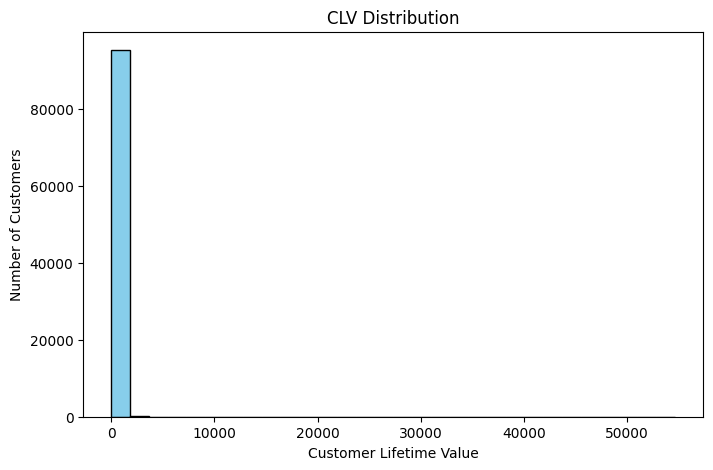

In [20]:
#  Visualizations
# Histogram: CLV distribution
plt.figure(figsize=(8,5))
plt.hist(customer_df['CLV'], bins=30, color='skyblue', edgecolor='black')
plt.title("CLV Distribution")
plt.xlabel("Customer Lifetime Value")
plt.ylabel("Number of Customers")
plt.show()


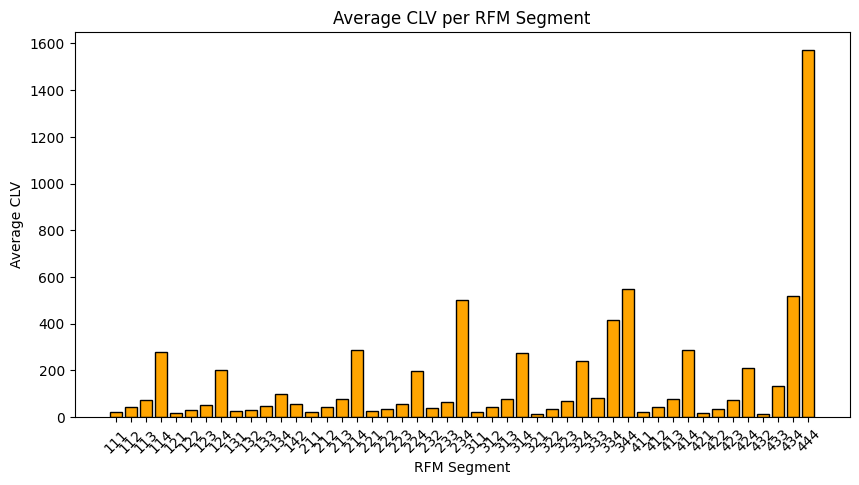

In [21]:
# Bar chart: Average CLV per RFM Segment
plt.figure(figsize=(10,5))
plt.bar(segment_clv['RFM_Segment'], segment_clv['CLV'], color='orange', edgecolor='black')
plt.title("Average CLV per RFM Segment")
plt.xlabel("RFM Segment")
plt.ylabel("Average CLV")
plt.xticks(rotation=45)
plt.show()

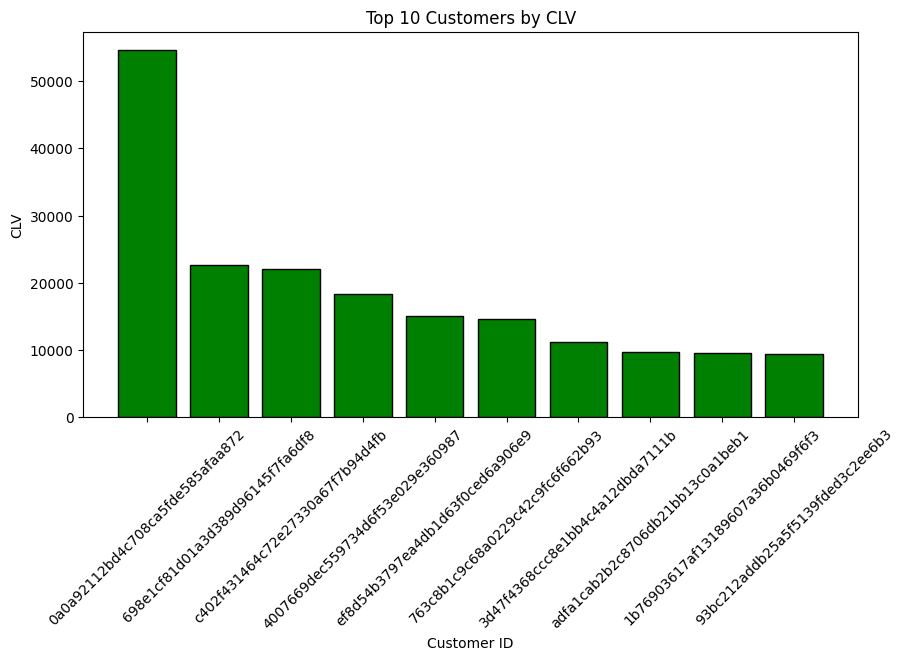

In [22]:
# Top 10 customers by CLV
plt.figure(figsize=(10,5))
plt.bar(top_10_customers['customer_unique_id'].astype(str), top_10_customers['CLV'], color='green', edgecolor='black')
plt.title("Top 10 Customers by CLV")
plt.xlabel("Customer ID")
plt.ylabel("CLV")
plt.xticks(rotation=45)
plt.show()


In [24]:
#  Save CLV Table (Deliverable)
customer_df.to_csv("CLV_table.csv", index=False)

print("CLV analysis complete!")

CLV analysis complete!


In [ ]:
import matplotlib
print(matplotlib.version)